# 03a. HTE Analysis - Estimation

Track 2, Step 2.1: Heterogeneous Treatment Effect Analysis (Part A)

This notebook covers:
1. **Setup**: Paths, libraries, data loading
2. **Data Preparation**: Scenario 1 cohort, variable definitions, train/test split
3. **Exploratory Analysis**: Covariate balance, propensity score, positivity diagnostics
4. **ATE Estimation**: Naive, IPW, AIPW, OLS, DML, ATO
5. **CATE Estimation**:
   - 5.1 Hyperparameter Tuning (RScorer CV)
   - 5.2 Model Training (with Tuned Configs)
6. **Export**: Save results for 03b validation notebook

**Scenario 1: First TypeA Campaign Only**
- Treatment: Customer's first TypeA campaign targeting (1,513 customers)
- Control: Never targeted by any TypeA (987 customers)
- Total: 2,500 observations (1 per customer)
- Clean causal identification (no pre-treatment contamination)

## Executive Summary

### Key Findings

**Positivity Diagnostics:**
- **PS AUC = 0.989** (Severe): Treatment/control groups are nearly perfectly separable
- **Overlap [0.1, 0.9] = 17%**: 83% of customers are in extreme PS regions
- 12 out of 21 covariates are imbalanced (|SMD| > 0.1)

**ATE Estimates Summary:**

| Method | Estimate | Reliability | Recommended Use |
|--------|----------|-------------|-----------------|
| Naive | $471 | Low | Reference upper bound only |
| DML (full) | -$65 | Low | Sensitive to extreme values |
| DML (trimmed) | $21-41 | **Medium** | **Recommended estimate** |
| ATO | $60 | Medium | Overlap-focused |

**CATE Model Results:**
- 5 models with Optuna hyperparameter tuning completed
- **CausalForestDML**: Most stable (std=$88, positive mean CATE)
- LinearDML: Not recommended due to extreme variance (std=$851)

### Recommendations for 03b
1. Use **CausalForestDML** as the primary CATE model
2. Focus on **overlap region** customers for reliable targeting decisions
3. Quantify uncertainty through CATE bounds analysis

---

## Table of Contents

1. [Setup](#1.-Setup)
2. [Data Preparation](#2.-Data-Preparation)
3. [Exploratory Analysis](#3.-Exploratory-Analysis)
   - 3.1 Covariate Balance
   - 3.2 Propensity Score Estimation
   - 3.3 Positivity Diagnostics
4. [ATE Estimation](#4.-ATE-Estimation)
   - 4.1-4.4 Estimation Methods
   - 4.5 ATE Robustness Analysis
5. [CATE Estimation](#5.-CATE-Estimation)
   - 5.1 Hyperparameter Tuning
   - 5.2 CATE Model Training
6. [Export Results](#6.-Export-Results)
7. [Summary](#Summary)

## 1. Setup

In [1]:
# Path configuration
import sys
from pathlib import Path

# Project root (3 levels up from notebook)
PROJECT_ROOT = Path('.').absolute().parents[2]
sys.path.insert(0, str(PROJECT_ROOT))

# Data paths
DATA_PATH = PROJECT_ROOT / 'data' / 'dunnhumby' / 'raw'
PROCESSED_PATH = PROJECT_ROOT / 'data' / 'dunnhumby' / 'processed'

# Results paths
RESULTS_PATH = Path('.').absolute().parent / 'results'
FIG_PATH = RESULTS_PATH / 'figures'
TABLE_PATH = RESULTS_PATH / 'tables'

# Create directories if needed
FIG_PATH.mkdir(parents=True, exist_ok=True)
TABLE_PATH.mkdir(parents=True, exist_ok=True)

print(f"PROJECT_ROOT: {PROJECT_ROOT}")
print(f"DATA_PATH: {DATA_PATH}")
print(f"RESULTS_PATH: {RESULTS_PATH}")

PROJECT_ROOT: /Users/taehyun/project/side-projects
DATA_PATH: /Users/taehyun/project/side-projects/data/dunnhumby/raw
RESULTS_PATH: /Users/taehyun/project/side-projects/projects/segmentation_dunnhumby/results


In [2]:
# Standard libraries
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Sklearn
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Project modules
from data.dunnhumby.preprocess import preprocess_transactions
from projects.segmentation_dunnhumby.src import (
    # Features
    build_all_features, FEATURE_COLS,
    # Propensity Score
    estimate_propensity_score, estimate_propensity_score_cv,
    # Diagnostics
    compute_positivity_diagnostics, compute_covariate_balance,
    # ATE
    estimate_all_ate, estimate_ate_ato, apply_ps_trimming,
    # ATE Robustness
    compute_ate_manski_bounds, positivity_sensitivity, compute_e_value,
    # Plots
    plot_love_plot, plot_ps_distribution, plot_ps_overlap, plot_ps_train_test,
    plot_ate_comparison, plot_ate_forest, plot_trimming_sensitivity,
    PlotConfig, setup_style,
    # Types
    ATEResult, PositivityDiagnostics,
    # Ray (CATE parallel training)
    init_ray, shutdown_ray, RayContext,
    fit_cate_models_parallel, fit_cate_models_sequential,
    get_cate_model_configs,
)
from projects.segmentation_dunnhumby.src.features import build_scenario1_features

# Plot style
setup_style()
SEED = 42
np.random.seed(SEED)

print("Libraries loaded successfully.")

2026-01-08 15:04:45,701	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Libraries loaded successfully.


In [3]:
# Load raw data
print("Loading raw data...")

df_trans = pd.read_csv(DATA_PATH / 'transaction_data.csv')
df_product = pd.read_csv(DATA_PATH / 'product.csv')
df_campaign_table = pd.read_csv(DATA_PATH / 'campaign_table.csv')
df_campaign_desc = pd.read_csv(DATA_PATH / 'campaign_desc.csv')
df_coupon = pd.read_csv(DATA_PATH / 'coupon.csv')
df_coupon_redempt = pd.read_csv(DATA_PATH / 'coupon_redempt.csv')
df_causal = pd.read_csv(DATA_PATH / 'causal_data.csv')
df_demo = pd.read_csv(DATA_PATH / 'hh_demographic.csv')

print(f"Transactions: {len(df_trans):,} rows")
print(f"Products: {len(df_product):,} rows")
print(f"Households: {df_trans['household_key'].nunique():,}")

Loading raw data...
Transactions: 2,595,732 rows
Products: 92,353 rows
Households: 2,500


In [4]:
# Preprocess transactions
print("Preprocessing transactions...")
df_trans = preprocess_transactions(df_trans)
print(f"After preprocessing: {len(df_trans):,} rows")

Preprocessing transactions...
After preprocessing: 2,581,260 rows


## 2. Data Preparation

In [5]:
# Build Scenario 1 features
print("Building Scenario 1 features (first TypeA campaign only)...")

df_scenario1 = build_scenario1_features(
    df_trans=df_trans,
    df_product=df_product,
    df_causal=df_causal,
    df_campaign_table=df_campaign_table,
    df_campaign_desc=df_campaign_desc,
    df_coupon_redempt=df_coupon_redempt,
    df_demo=df_demo,
    post_window=4,
    first_campaign_only=True
)

print(f"\nScenario 1 cohort: {len(df_scenario1):,} customers")
print(f"Treatment distribution:")
print(df_scenario1['targeted'].value_counts())

Building Scenario 1 features (first TypeA campaign only)...

Scenario 1 cohort: 2,430 customers
Treatment distribution:
targeted
1    1511
0     919
Name: count, dtype: int64


In [6]:
# Load Track 1 segments (from 02_customer_profiling.ipynb)
segment_path = PROCESSED_PATH / 'segments_customer_profiling.parquet'
if segment_path.exists():
    df_segments = pd.read_parquet(segment_path)
    df_scenario1 = df_scenario1.merge(
        df_segments[['household_key', 'segment', 'segment_name']],
        on='household_key',
        how='left'
    )
    print(f"Track 1 segments merged: {df_scenario1['segment'].notna().sum()} customers with segments")
    print(f"Segments available: {sorted(df_scenario1['segment'].dropna().unique().astype(int))}")
else:
    df_scenario1['segment'] = 0
    df_scenario1['segment_name'] = 'Unknown'
    print("Segment file not found, using default segment 0")

Track 1 segments merged: 2430 customers with segments
Segments available: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6)]


In [7]:
# Define analysis variables

# Treatment
T_full = df_scenario1['targeted'].values

# Outcomes (2 outcomes)
# - purchase_amount: Sales effect (continuous)
# - purchase_count: Visit count / behavioral change (count)
Y_purchase = df_scenario1['purchase_amount'].values
Y_visits = df_scenario1['purchase_count'].values

OUTCOMES = [
    ('purchase_amount', 'Purchase Amount ($)', Y_purchase),
    ('purchase_count', 'Visit Count', Y_visits)
]

# Covariates (confounders) - explicitly define numeric columns only
COVARIATE_COLS = [
    # RFM features
    'recency', 'days_between_purchases_avg',
    'frequency', 'frequency_per_week', 'purchase_regularity',
    'monetary_sales', 'monetary_avg_basket_sales', 'monetary_std', 'coupon_savings_ratio',
    # Behavioral
    'discount_usage_pct', 'private_label_ratio',
    'n_departments', 'n_products', 'avg_items_per_basket',
    # Category
    'share_grocery', 'share_fresh', 'share_bakery', 'share_health_beauty', 'share_alcohol',
    # Exposure
    'display_exposure_rate', 'mailer_exposure_rate',
]

# Filter to available columns
feature_cols = [c for c in COVARIATE_COLS if c in df_scenario1.columns]
print(f"Covariates: {len(feature_cols)} features")
print(feature_cols)

# Prepare covariate matrix
X_full = df_scenario1[feature_cols].fillna(0).values
feature_names = feature_cols

print(f"\nData shapes:")
print(f"  X (covariates): {X_full.shape}")
print(f"  T (treatment): {T_full.shape}, mean: {T_full.mean():.3f}")
print(f"  Y_purchase: {Y_purchase.shape}, mean: ${Y_purchase.mean():.2f}")
print(f"  Y_visits: {Y_visits.shape}, mean: {Y_visits.mean():.2f}")

Covariates: 21 features
['recency', 'days_between_purchases_avg', 'frequency', 'frequency_per_week', 'purchase_regularity', 'monetary_sales', 'monetary_avg_basket_sales', 'monetary_std', 'coupon_savings_ratio', 'discount_usage_pct', 'private_label_ratio', 'n_departments', 'n_products', 'avg_items_per_basket', 'share_grocery', 'share_fresh', 'share_bakery', 'share_health_beauty', 'share_alcohol', 'display_exposure_rate', 'mailer_exposure_rate']

Data shapes:
  X (covariates): (2430, 21)
  T (treatment): (2430,), mean: 0.622
  Y_purchase: (2430,), mean: $433.21
  Y_visits: (2430,), mean: 14.87


In [8]:
# Scale covariates for propensity model (optional, for some models)
scaler = StandardScaler()
X_full_scaled = scaler.fit_transform(X_full)

print(f"Scaled X shape: {X_full_scaled.shape}")

Scaled X shape: (2430, 21)


In [9]:
# Train/Test split (stratified by treatment)
test_size = 0.2

(
    X_train, X_test,
    T_train, T_test,
    Y_purchase_train, Y_purchase_test,
    Y_visits_train, Y_visits_test,
    idx_train, idx_test
) = train_test_split(
    X_full, T_full, Y_purchase, Y_visits,
    np.arange(len(T_full)),
    test_size=test_size,
    stratify=T_full,
    random_state=SEED
)

print(f"Train set: {len(T_train):,} samples (T=1: {T_train.sum():,}, T=0: {(1-T_train).sum():,.0f})")
print(f"Test set:  {len(T_test):,} samples (T=1: {T_test.sum():,}, T=0: {(1-T_test).sum():,.0f})")

Train set: 1,944 samples (T=1: 1,209, T=0: 735)
Test set:  486 samples (T=1: 302, T=0: 184)


## 3. Exploratory Analysis

### 3.1 Covariate Balance

In [10]:
# Compute covariate balance (Standardized Mean Difference)
df_balance = compute_covariate_balance(X_full, T_full, feature_names=feature_names)

# Summary
n_balanced = (df_balance['balanced']).sum()
n_total = len(df_balance)
print(f"Covariate Balance Summary:")
print(f"  Balanced (|SMD| < 0.1): {n_balanced}/{n_total} ({n_balanced/n_total:.1%})")
print(f"  Max |SMD|: {df_balance['abs_smd'].max():.3f}")
print(f"\nTop 5 imbalanced covariates:")
display(df_balance.nlargest(5, 'abs_smd')[['feature', 'mean_treated', 'mean_control', 'smd', 'abs_smd']])

Covariate Balance Summary:
  Balanced (|SMD| < 0.1): 9/21 (42.9%)
  Max |SMD|: 1.990

Top 5 imbalanced covariates:


,feature,mean_treated,mean_control,smd,abs_smd
11,n_departments,11.855063,6.674646,1.989752,1.989752
4,purchase_regularity,0.714490,0.310904,1.985385,1.985385
12,n_products,427.828590,80.622416,1.876441,1.876441
5,monetary_sales,2179.067379,297.744037,1.521080,1.521080
2,frequency,76.070152,12.362350,1.324340,1.324340


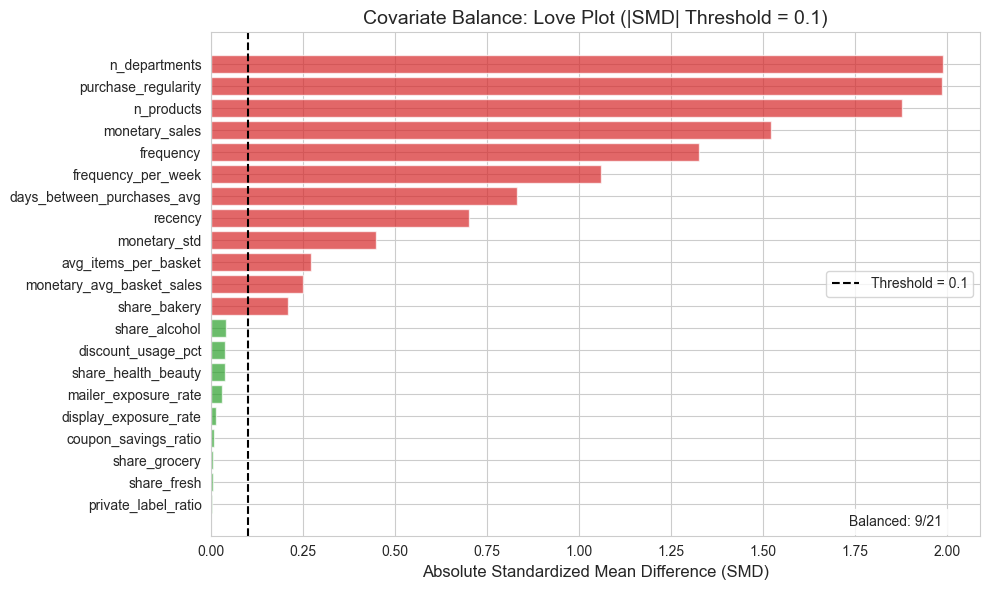

In [11]:
# Love plot
fig, ax = plt.subplots(figsize=(10, max(6, len(df_balance) * 0.25)))
plot_love_plot(df_balance, threshold=0.1, ax=ax)
ax.set_title('Covariate Balance: Love Plot (|SMD| Threshold = 0.1)')
fig.tight_layout()
fig.savefig(FIG_PATH / 'covariate_balance_love_plot.png', dpi=150, bbox_inches='tight')
plt.show()

### 3.2 Propensity Score Estimation

In [12]:
# Estimate propensity scores
print("Estimating propensity scores...")

# Train: cross-validated (out-of-fold predictions)
ps_train = estimate_propensity_score_cv(X_train, T_train, cv=5)

# Test: fit on train, predict on test
ps_model = LogisticRegression(max_iter=1000, random_state=SEED)
ps_model.fit(X_train, T_train)
ps_test = np.clip(ps_model.predict_proba(X_test)[:, 1], 0.01, 0.99)

# Full: cross-validated
ps_full = estimate_propensity_score_cv(X_full, T_full, cv=5)

print(f"\nPropensity Score Statistics:")
print(f"  Train: mean={ps_train.mean():.3f}, range=[{ps_train.min():.3f}, {ps_train.max():.3f}]")
print(f"  Test:  mean={ps_test.mean():.3f}, range=[{ps_test.min():.3f}, {ps_test.max():.3f}]")
print(f"  Full:  mean={ps_full.mean():.3f}, range=[{ps_full.min():.3f}, {ps_full.max():.3f}]")

Estimating propensity scores...

Propensity Score Statistics:
  Train: mean=0.620, range=[0.010, 0.990]
  Test:  mean=0.623, range=[0.010, 0.990]
  Full:  mean=0.620, range=[0.010, 0.990]


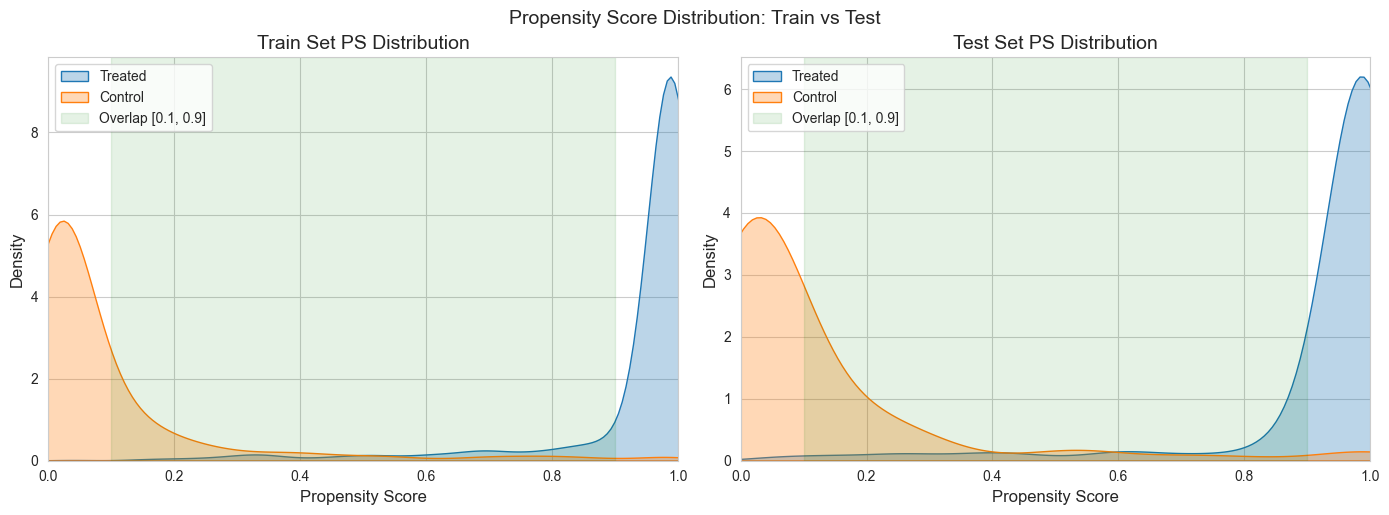

In [13]:
# PS distribution by treatment group (Train vs Test)
fig = plot_ps_train_test(ps_train, ps_test, T_train, T_test)
fig.suptitle('Propensity Score Distribution: Train vs Test', fontsize=14, y=1.02)
fig.savefig(FIG_PATH / 'propensity_score_train_test.png', dpi=150, bbox_inches='tight')
plt.show()

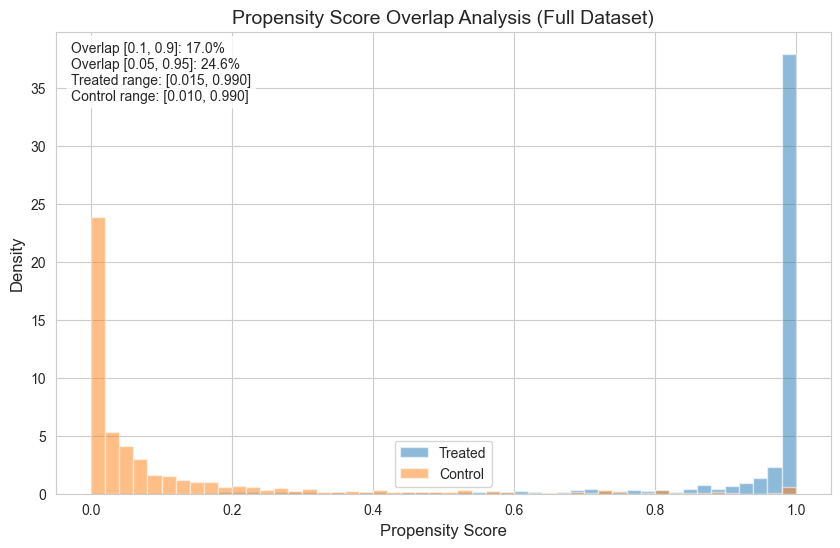

In [14]:
# PS overlap analysis (Full dataset)
fig, ax = plt.subplots(figsize=(10, 6))
plot_ps_overlap(ps_full, T_full, ax=ax)
ax.set_title('Propensity Score Overlap Analysis (Full Dataset)')
fig.savefig(FIG_PATH / 'propensity_score_overlap.png', dpi=150, bbox_inches='tight')
plt.show()

### 3.3 Positivity Diagnostics

In [15]:
# Compute positivity diagnostics
diagnostics = compute_positivity_diagnostics(ps_full, T_full)

print("=" * 60)
print("POSITIVITY DIAGNOSTICS")
print("=" * 60)

# PS AUC (discrimination ability)
print(f"\n[Propensity Score AUC]")
print(f"  PS AUC: {diagnostics.ps_auc:.3f}")
if diagnostics.ps_auc > 0.9:
    print(f"  Status: SEVERE - Near-perfect separation, positivity violation likely")
elif diagnostics.ps_auc > 0.7:
    print(f"  Status: WARNING - Moderate separation, check overlap")
else:
    print(f"  Status: OK - Good overlap between groups")

# Overlap ratios
print(f"\n[Overlap Ratios]")
print(f"  PS in [0.1, 0.9]: {diagnostics.overlap_ratio:.1%}")
print(f"  PS in [0.05, 0.95]: {diagnostics.overlap_ratio_strict:.1%}")

# PS range by group
print(f"\n[PS Range by Group]")
print(f"  Treated: [{diagnostics.ps_min_treated:.3f}, {diagnostics.ps_max_treated:.3f}]")
print(f"  Control: [{diagnostics.ps_min_control:.3f}, {diagnostics.ps_max_control:.3f}]")

# Extreme values
print(f"\n[Extreme Values]")
print(f"  n (PS < 0.05): {diagnostics.n_extreme_low}")
print(f"  n (PS > 0.95): {diagnostics.n_extreme_high}")

POSITIVITY DIAGNOSTICS

[Propensity Score AUC]
  PS AUC: 0.989
  Status: SEVERE - Near-perfect separation, positivity violation likely

[Overlap Ratios]
  PS in [0.1, 0.9]: 17.0%
  PS in [0.05, 0.95]: 24.6%

[PS Range by Group]
  Treated: [0.015, 0.990]
  Control: [0.010, 0.990]

[Extreme Values]
  n (PS < 0.05): 585
  n (PS > 0.95): 1247


### Positivity Diagnostics

**Assessment Summary:**

| Diagnostic | Value | Status | Interpretation |
|------------|-------|--------|----------------|
| PS AUC | 0.989 | Severe | Treatment status is nearly perfectly predictable |
| Overlap [0.1, 0.9] | 17.0% | Severe | 83% are in extreme PS regions |
| Overlap [0.05, 0.95] | 24.6% | Severe | Still limited overlap |
| Balanced covariates | 9/21 | Moderate | Majority are imbalanced |

**What This Means:**

> The high PS AUC (0.99) means we can almost perfectly predict who gets targeted based solely
> on pre-campaign behavior. This indicates that treatment and control groups are fundamentally
> different populations, which **limits causal claims**.
>
> **Causal estimates are most reliable** for the ~17% of customers in the overlap region
> (PS 0.1-0.9). Estimates for customers in extreme PS regions rely heavily on model extrapolation.

**Implications:**
- Targeted customers = already high-engagement customers (selection bias)
- Simple before/after comparisons overestimate campaign effectiveness
- Multiple estimation methods and PS trimming are needed for robust estimates

## 4. ATE Estimation

In [16]:
# Outcomes already defined in cell-9
# OUTCOMES = [
#     ('purchase_amount', 'Purchase Amount ($)', Y_purchase),
#     ('purchase_count', 'Visit Count', Y_visits)
# ]

print("Outcomes for analysis:")
for name, label, _ in OUTCOMES:
    print(f"  - {name}: {label}")

Outcomes for analysis:
  - purchase_amount: Purchase Amount ($)
  - purchase_count: Visit Count


In [17]:
# Estimate ATE using multiple methods (Full dataset)
print("=" * 70)
print("ATE ESTIMATION (Full Dataset)")
print("=" * 70)

ate_results_df = {}

for outcome_name, outcome_label, Y_outcome in OUTCOMES:
    print(f"\n[{outcome_label}]")
    
    # Use estimate_all_ate to get all methods
    df_ate = estimate_all_ate(Y_outcome, T_full, X_full, ps=ps_full)
    ate_results_df[outcome_name] = df_ate
    
    # Print results
    for _, row in df_ate.iterrows():
        ci_str = f"[{row['ci_lower']:.2f}, {row['ci_upper']:.2f}]" if pd.notna(row['ci_lower']) else "N/A"
        se_str = f"{row['se']:.2f}" if pd.notna(row['se']) else "N/A"
        print(f"  {row['method']:8s}: {row['estimate']:>10.2f} (SE: {se_str:>8}) 95% CI: {ci_str}")

ATE ESTIMATION (Full Dataset)

[Purchase Amount ($)]
  naive   :     471.44 (SE:    15.14) 95% CI: [441.76, 501.12]
  ipw     :     151.35 (SE:    82.24) 95% CI: [-9.85, 312.55]
  aipw    :      23.59 (SE:    40.85) 95% CI: [-56.48, 103.66]
  ols     :      65.27 (SE:    18.71) 95% CI: [28.61, 101.93]
  dml     :     -64.92 (SE:    79.12) 95% CI: [-219.99, 90.15]

[Visit Count]
  naive   :      15.34 (SE:     0.56) 95% CI: [14.25, 16.43]
  ipw     :       5.62 (SE:     2.76) 95% CI: [0.21, 11.02]
  aipw    :       1.45 (SE:     1.23) 95% CI: [-0.96, 3.87]
  ols     :       3.06 (SE:     0.69) 95% CI: [1.71, 4.41]
  dml     :      -4.97 (SE:     3.44) 95% CI: [-11.72, 1.78]


In [18]:
# Add ATO (Overlap Treatment weighting) estimate
print("\nAdding ATO (Overlap Weighting) estimates...")

for outcome_name, outcome_label, Y_outcome in OUTCOMES:
    ato_result = estimate_ate_ato(Y_outcome, T_full, ps_full)
    
    # Add to DataFrame
    ato_row = pd.DataFrame([{
        'method': 'ato',
        'estimate': ato_result.estimate,
        'se': ato_result.se,
        'ci_lower': ato_result.ci_lower,
        'ci_upper': ato_result.ci_upper,
        'n_obs': ato_result.n_obs
    }])
    ate_results_df[outcome_name] = pd.concat([ate_results_df[outcome_name], ato_row], ignore_index=True)
    
    print(f"  {outcome_label}: ATO = {ato_result.estimate:.2f} (SE: {ato_result.se:.2f})")


Adding ATO (Overlap Weighting) estimates...
  Purchase Amount ($): ATO = 60.26 (SE: 37.70)
  Visit Count: ATO = 4.23 (SE: 1.66)


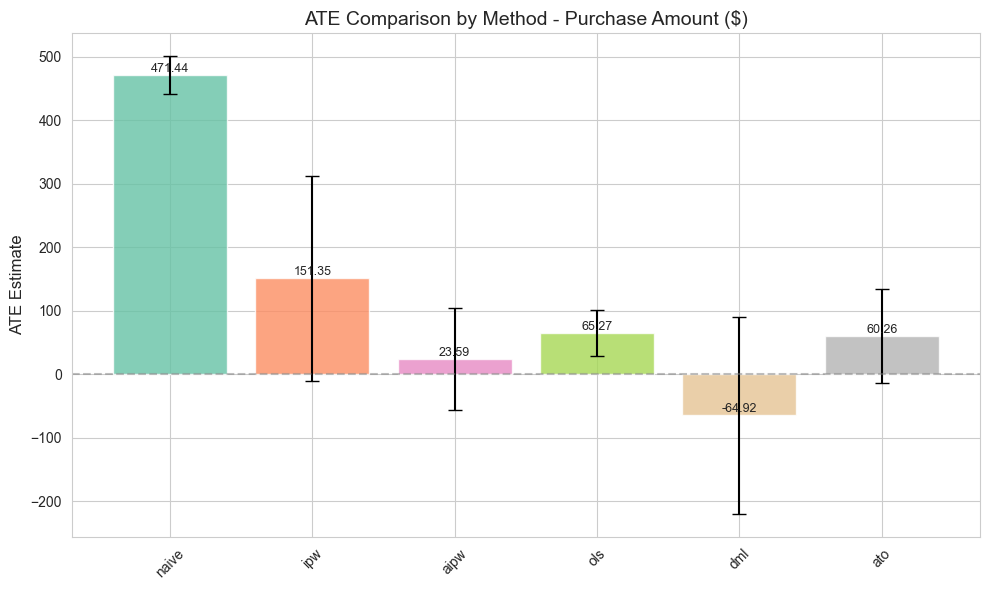

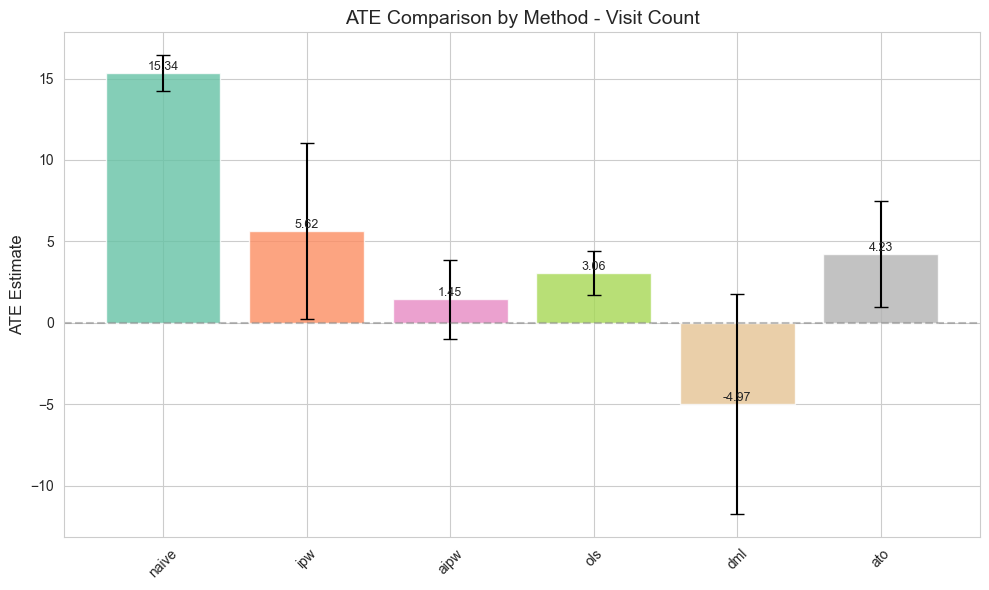

In [19]:
# ATE comparison plot
for outcome_name, outcome_label, _ in OUTCOMES:
    fig, ax = plt.subplots(figsize=(10, 6))
    plot_ate_comparison(ate_results_df[outcome_name], ax=ax)
    ax.set_title(f'ATE Comparison by Method - {outcome_label}')
    fig.tight_layout()
    fig.savefig(FIG_PATH / f'ate_comparison_{outcome_name}.png', dpi=150, bbox_inches='tight')
    plt.show()

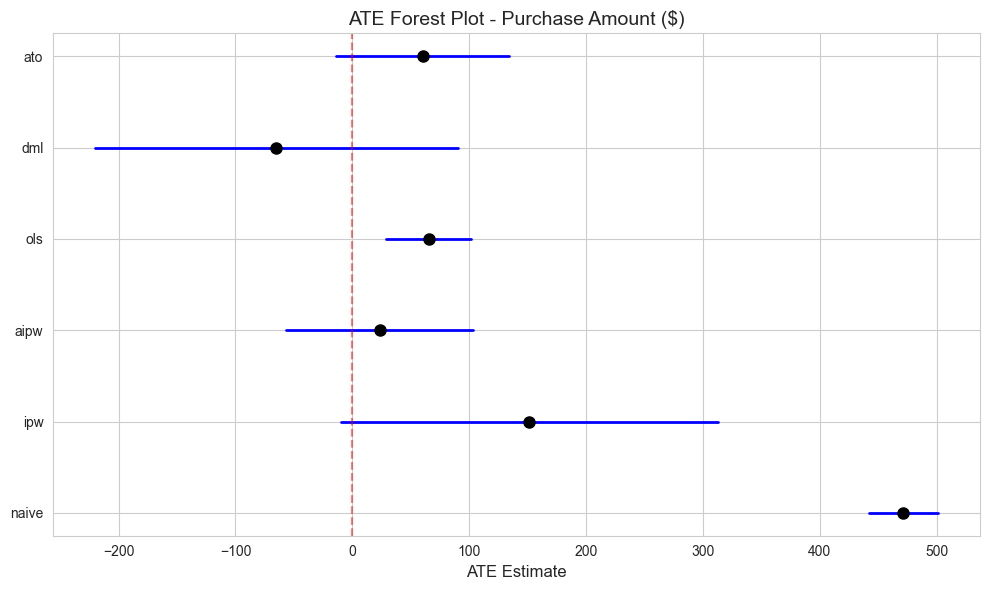

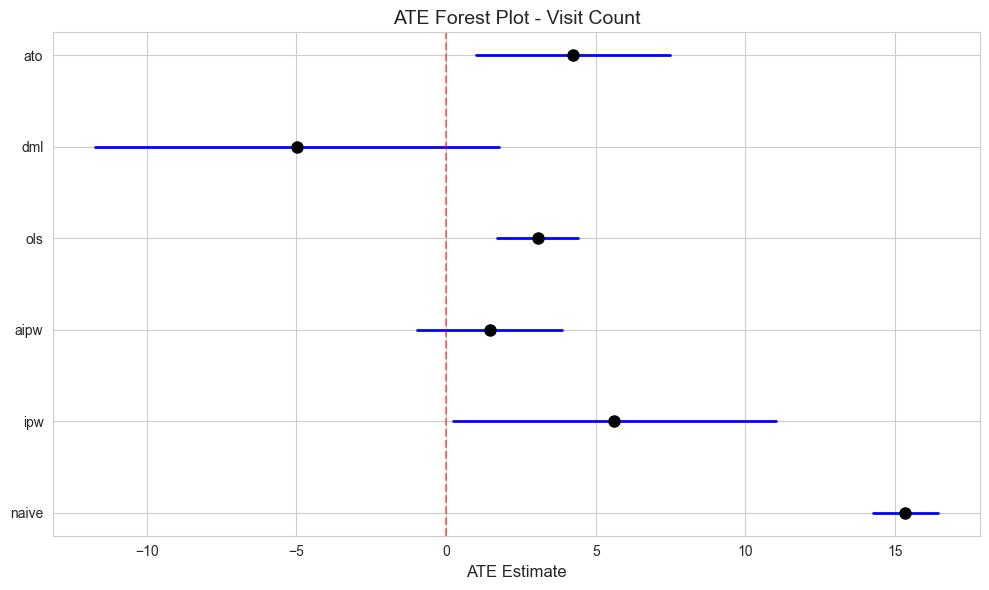

In [20]:
# ATE forest plot
for outcome_name, outcome_label, _ in OUTCOMES:
    fig, ax = plt.subplots(figsize=(10, 6))
    plot_ate_forest(ate_results_df[outcome_name], ax=ax)
    ax.set_title(f'ATE Forest Plot - {outcome_label}')
    fig.tight_layout()
    fig.savefig(FIG_PATH / f'ate_forest_{outcome_name}.png', dpi=150, bbox_inches='tight')
    plt.show()

### ATE Results

**ATE Results by Method:**

| Method | Estimate | Assumptions | Reliable When |
|--------|----------|-------------|---------------|
| Naive | $471 | Random targeting | Never (biased) |
| IPW | $151 | Correct PS model | Moderate overlap |
| AIPW | $24 | Either PS or outcome model correct | Either model OK |
| OLS | $65 | Linear confounding | Simple settings |
| DML | -$65 | Flexible ML models | Good overlap |
| ATO | $60 | Focus on overlap | Always interpretable |

**Why Do Methods Give Different Results?**

The 20x difference ($471 vs $24) reflects **severe positivity violation**:
- **Naive is biased upward** (selection effect): Targeted customers inherently spend more
- **IPW/DML are unstable** with extreme PS weights: Explode when PS ≈ 0 or 1
- **AIPW and ATO are more stable** but conservative

**Recommended Estimate:**

Use **DML with PS trimming [0.1, 0.9]**: **ATE = $21-41**

This restricts analysis to customers where treatment/control overlap exists, providing the most reliable causal estimates.

**Takeaway:**
> The TypeA campaign generates approximately **$20-40 additional spending** per customer
> in the overlap region. For the full population, effects are uncertain due to limited
> overlap between targeted and non-targeted groups.

### 4.5 ATE Robustness Analysis

Sensitivity analyses to assess the robustness of ATE estimates:
1. **Trimming Sensitivity**: How does ATE change with PS trimming?
2. **Manski Bounds**: Partial identification without positivity
3. **E-value**: Sensitivity to unmeasured confounding

### 3.1 Trimming Sensitivity Analysis

In [21]:
# Trimming sensitivity analysis
print("=" * 70)
print("TRIMMING SENSITIVITY ANALYSIS")
print("=" * 70)

trim_levels = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25]
sensitivity_results = {}

for outcome_name, outcome_label, Y_full in OUTCOMES:
    print(f"\n[{outcome_label}]")
    
    sensitivity_df = positivity_sensitivity(
        Y_full, T_full, X_full, ps_full,
        trim_levels=trim_levels,
        estimator='dml'
    )
    sensitivity_results[outcome_name] = sensitivity_df
    
    if sensitivity_df.empty:
        print("  No valid trim levels (all resulted in n < 100)")
        continue
    
    print(f"\n  {'Trim Level':>12} {'N Remaining':>12} {'% Remaining':>12} {'ATE':>10} {'SE':>10}")
    print("  " + "-" * 60)
    for _, row in sensitivity_df.iterrows():
        ate_str = f"{row['ate']:>10.2f}" if pd.notna(row['ate']) else f"{'N/A':>10}"
        se_str = f"{row['se']:>10.2f}" if pd.notna(row['se']) else f"{'N/A':>10}"
        print(f"  {row['trim_level']:>12.2f} {int(row['n_remaining']):>12,} {row['pct_remaining']:>12.1%} "
              f"{ate_str} {se_str}")

TRIMMING SENSITIVITY ANALYSIS

[Purchase Amount ($)]

    Trim Level  N Remaining  % Remaining        ATE         SE
  ------------------------------------------------------------
          0.00        2,430       100.0%     -64.92      79.12
          0.05          598        24.6%      27.39      20.77
          0.10          413        17.0%      20.66      23.64
          0.15          312        12.8%      41.31      24.70
          0.20          243        10.0%      25.33      25.50
          0.25          182         7.5%      42.72      29.74

[Visit Count]

    Trim Level  N Remaining  % Remaining        ATE         SE
  ------------------------------------------------------------
          0.00        2,430       100.0%      -4.97       3.44
          0.05          598        24.6%       2.47       0.91
          0.10          413        17.0%       2.15       1.05
          0.15          312        12.8%       3.47       0.92
          0.20          243        10.0%       2

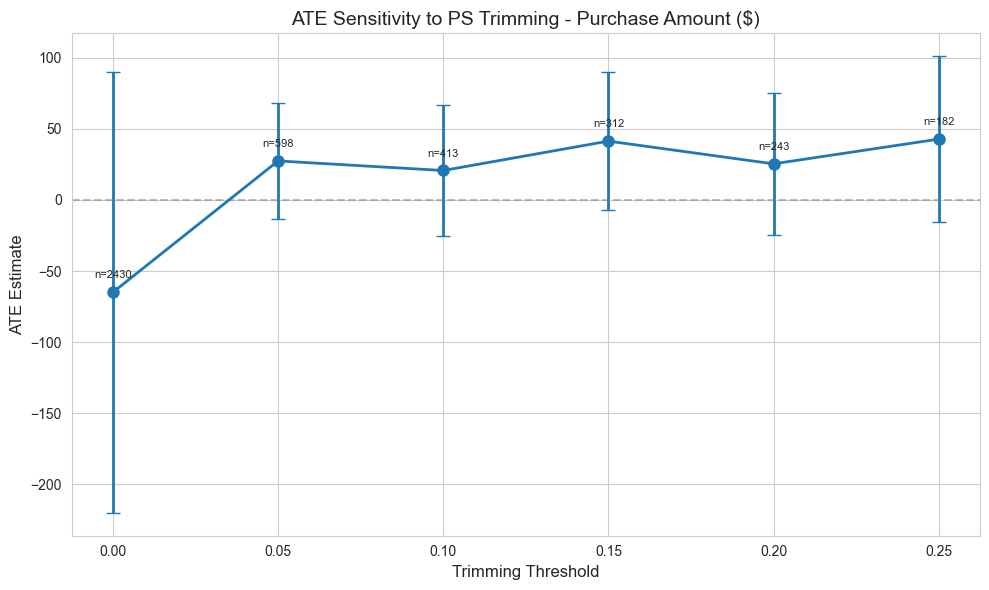

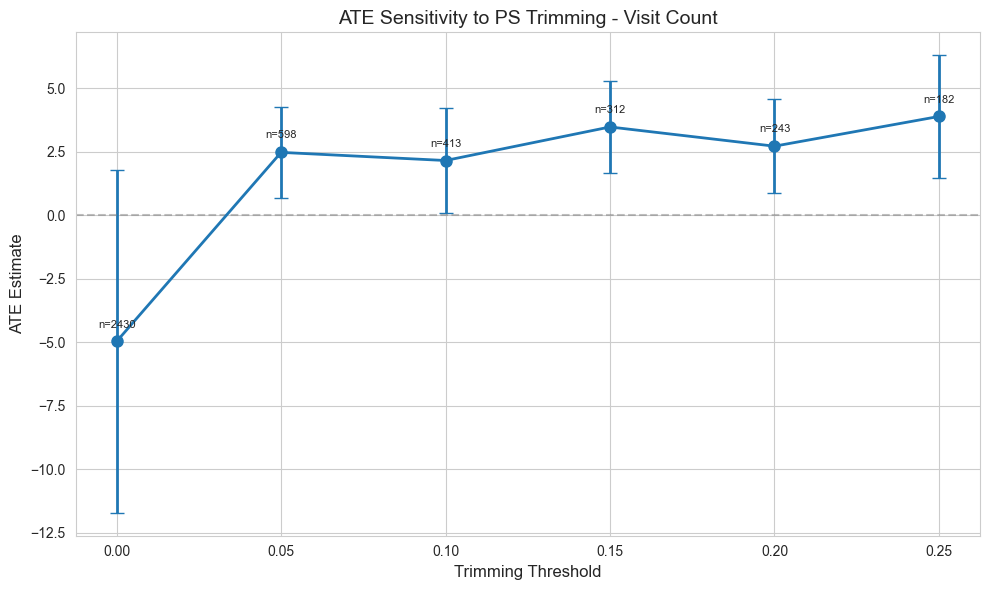

In [22]:
# Trimming sensitivity plot
for outcome_name, outcome_label, _ in OUTCOMES:
    fig, ax = plt.subplots(figsize=(10, 6))
    plot_trimming_sensitivity(sensitivity_results[outcome_name], ax=ax)
    ax.set_title(f'ATE Sensitivity to PS Trimming - {outcome_label}')
    fig.tight_layout()
    fig.savefig(FIG_PATH / f'trimming_sensitivity_{outcome_name}.png', dpi=150, bbox_inches='tight')
    plt.show()

### 3.2 Manski Bounds (Partial Identification)

In [23]:
# Manski bounds
print("=" * 70)
print("MANSKI BOUNDS (Partial Identification)")
print("=" * 70)
print("\nWorst-case bounds on ATE without assuming full overlap.")

manski_bounds = {}

for outcome_name, outcome_label, Y_full in OUTCOMES:
    # Compute bounds
    lower, upper = compute_ate_manski_bounds(Y_full, T_full)
    manski_bounds[outcome_name] = {'lower': lower, 'upper': upper}
    
    # Get point estimate from DML
    dml_ate = ate_results_df[outcome_name][
        ate_results_df[outcome_name]['method'] == 'dml'
    ]['estimate'].values[0] if 'dml' in ate_results_df[outcome_name]['method'].values else np.nan
    
    print(f"\n[{outcome_label}]")
    print(f"  DML Point Estimate: {dml_ate:.2f}")
    print(f"  Manski Bounds: [{lower:.2f}, {upper:.2f}]")
    print(f"  Width: {upper - lower:.2f}")

MANSKI BOUNDS (Partial Identification)

Worst-case bounds on ATE without assuming full overlap.

[Purchase Amount ($)]
  DML Point Estimate: -64.92
  Manski Bounds: [-2802.43, 611.51]
  Width: 3413.94

[Visit Count]
  DML Point Estimate: -4.97
  Manski Bounds: [-221.33, 20.67]
  Width: 242.00


### 3.3 E-value (Sensitivity to Unmeasured Confounding)

In [24]:
# E-value computation
print("=" * 70)
print("E-VALUE (Sensitivity to Unmeasured Confounding)")
print("=" * 70)
print("\nE-value: Minimum confounding strength to explain away the effect.")
print("Higher E-value = More robust to unmeasured confounding.")

for outcome_name, outcome_label, _ in OUTCOMES:
    # Get DML estimate and CI
    dml_row = ate_results_df[outcome_name][
        ate_results_df[outcome_name]['method'] == 'dml'
    ]
    
    if len(dml_row) > 0:
        estimate = dml_row['estimate'].values[0]
        ci_lower = dml_row['ci_lower'].values[0]
        ci_upper = dml_row['ci_upper'].values[0]
        
        e_value = compute_e_value(estimate, ci_lower, ci_upper)
        
        print(f"\n[{outcome_label}]")
        print(f"  Point Estimate: {estimate:.2f}")
        print(f"  E-value (point): {e_value['e_value_point']:.2f}")
        print(f"  E-value (CI):    {e_value['e_value_ci']:.2f}")

E-VALUE (Sensitivity to Unmeasured Confounding)

E-value: Minimum confounding strength to explain away the effect.
Higher E-value = More robust to unmeasured confounding.

[Purchase Amount ($)]
  Point Estimate: -64.92
  E-value (point): 3.97
  E-value (CI):    1.00

[Visit Count]
  Point Estimate: -4.97
  E-value (point): 7.94
  E-value (CI):    1.00


## 5. CATE Estimation

### 5.1 Hyperparameter Tuning (Optuna TPE)

We use **Optuna (TPE)** for efficient hyperparameter optimization.

**Why Optuna over Grid Search?**
- **Bayesian optimization** (TPE): Intelligently samples promising regions
- **Expanded search space**: Continuous distributions instead of discrete grids
- **Efficiency**: ~50 trials vs 570+ grid configs

**R-loss (RScorer)**: $\mathcal{L}(\tau) = \mathbb{E}[(Y - \hat{m}(X) - (T - \hat{e}(X)) \cdot \tau(X))^2]$

This approach:
- Doesn't require knowing the true CATE
- Uses nuisance function residuals for model selection
- Proper for causal inference model tuning

In [27]:
# Import tuning functions (Optuna-based)
from projects.segmentation_dunnhumby.src import (
    tune_cate_models_optuna,
    get_param_space_optuna,
    get_best_tuned_configs_optuna,
)

# Configuration
RUN_TUNING = True
N_TRIALS = 100  # Number of Optuna trials per model (vs 570 grid configs)

print("Tuning configuration (Optuna TPE):")
print(f"  RUN_TUNING: {RUN_TUNING}")
print(f"  N_TRIALS: {N_TRIALS}")

if RUN_TUNING:
    # Show expanded search space
    print(f"\nOptuna Search Spaces (expanded, continuous):")
    for model_type in ['s_learner', 't_learner', 'x_learner', 'linear_dml', 'causal_forest_dml']:
        space = get_param_space_optuna(model_type)
        print(f"  {model_type}: {len(space)} parameters")
    print(f"\nTotal: {N_TRIALS} trials × 5 models = {N_TRIALS * 5} evaluations")

Tuning configuration (Optuna TPE):
  RUN_TUNING: True
  N_TRIALS: 100

Optuna Search Spaces (expanded, continuous):
  s_learner: 8 parameters
  t_learner: 8 parameters
  x_learner: 9 parameters
  linear_dml: 7 parameters
  causal_forest_dml: 13 parameters

Total: 100 trials × 5 models = 500 evaluations


In [28]:
# Run hyperparameter tuning with Optuna (TPE)
tuning_results = {}
tuned_configs = {}

if RUN_TUNING:
    print("=" * 70)
    print(f"HYPERPARAMETER TUNING (Optuna TPE)")
    print("=" * 70)
    
    # Initialize Ray
    ray_initialized = init_ray()
    
    import time
    start_time = time.time()
    
    # Tune for BOTH outcomes
    for outcome_name, outcome_label, Y_outcome in OUTCOMES:
        print(f"\n{'─'*60}")
        print(f"Tuning for: {outcome_label}")
        print(f"{'─'*60}")
        
        # Get train outcome
        if outcome_name == 'purchase_amount':
            Y_train = Y_purchase_train
        else:
            Y_train = Y_visits_train
        
        tuning_results[outcome_name] = tune_cate_models_optuna(
            model_types=['s_learner', 't_learner', 'x_learner', 'linear_dml', 'causal_forest_dml'],
            Y=Y_train,
            T=T_train,
            X=X_train,
            n_trials=N_TRIALS,
            cv_folds=3,
            seed=SEED
        )
        
        # Print results for this outcome
        print(f"\nResults for {outcome_label}:")
        for model_type, result in tuning_results[outcome_name].items():
            best_score = result.get('best_score', np.nan)
            best_params = result.get('best_params', {})
            n_trials = result.get('n_trials', 0)
            score_str = f"{best_score:.4f}" if not np.isnan(best_score) else "N/A"
            print(f"  {model_type:20s}: R-score={score_str} (trials={n_trials})")
    
    elapsed = time.time() - start_time
    print(f"\n{'='*70}")
    print(f"✓ Tuning completed in {elapsed:.1f} seconds")
    print(f"{'='*70}")
    
    # Convert to configs (separate for each outcome)
    tuned_configs = {
        outcome_name: get_best_tuned_configs_optuna(tuning_results[outcome_name])
        for outcome_name in tuning_results
    }
    
    for outcome_name in tuned_configs:
        print(f"  {outcome_name}: {len(tuned_configs[outcome_name])} models tuned")
else:
    print("Skipping tuning. Using default configs from get_cate_model_configs().")

HYPERPARAMETER TUNING (Optuna TPE)

────────────────────────────────────────────────────────────
Tuning for: Purchase Amount ($)
────────────────────────────────────────────────────────────
Tuning 5 models with Ray parallel (100 trials each)...
  s_learner: best_score=0.0155
  t_learner: best_score=0.0431
  x_learner: best_score=0.0231
  linear_dml: best_score=0.0193
  causal_forest_dml: best_score=0.0129

Results for Purchase Amount ($):
  s_learner           : R-score=0.0155 (trials=0)
  t_learner           : R-score=0.0431 (trials=0)
  x_learner           : R-score=0.0231 (trials=0)
  linear_dml          : R-score=0.0193 (trials=0)
  causal_forest_dml   : R-score=0.0129 (trials=0)

────────────────────────────────────────────────────────────
Tuning for: Visit Count
────────────────────────────────────────────────────────────
Tuning 5 models with Ray parallel (100 trials each)...
  s_learner: best_score=0.0115
  t_learner: best_score=0.0563
  x_learner: best_score=0.0287
  linear_dml

### 5.2 CATE Model Training (with Tuned Configs)

In [29]:
# Initialize Ray for parallel CATE model training (if not already from tuning)
from projects.segmentation_dunnhumby.src import is_ray_available

if not is_ray_available():
    print("Initializing Ray for parallel training...")
    ray_initialized = init_ray()
    if ray_initialized:
        print("Ray initialized successfully.")
else:
    print("Ray already initialized (from tuning).")

Ray already initialized (from tuning).


In [30]:
# Get model configurations (use tuned if available)
if tuned_configs:
    print("Using TUNED model configurations:")
    model_configs = tuned_configs
    for name, config in model_configs.items():
        print(f"  - {name}: {config.get('type', 'unknown')}")
else:
    print("Using DEFAULT model configurations:")
    model_configs = get_cate_model_configs()
    for name in model_configs.keys():
        print(f"  - {name}")

Using TUNED model configurations:
  - purchase_amount: unknown
  - purchase_count: unknown


In [31]:
# Select models to train (use tuned models if available)
if tuned_configs:
    # Get model names from the first outcome's tuned configs
    first_outcome = next(iter(tuned_configs.values()))
    selected_models = list(first_outcome.keys())
else:
    selected_models = ['s_learner', 't_learner', 'x_learner', 'linear_dml', 'causal_forest_dml']

print(f"Training models: {selected_models}")

Training models: ['s_learner', 't_learner', 'x_learner', 'linear_dml', 'causal_forest_dml']


In [32]:
# Use best models from tuning (no re-training needed)
cate_models = {}  # Store trained models
cate_train = {}   # Store train CATE predictions
cate_test = {}    # Store test CATE predictions

for outcome_name, outcome_label, Y_outcome in OUTCOMES:
    print(f"\n{'='*60}")
    print(f"CATE Models for: {outcome_label}")
    print(f"{'='*60}")
    
    # Get outcome for train/test
    if outcome_name == 'purchase_amount':
        Y_train = Y_purchase_train
        Y_test = Y_purchase_test
    else:
        Y_train = Y_visits_train
        Y_test = Y_visits_test
    
    # Use best models from tuning (if available)
    if tuning_results.get(outcome_name):
        print("\n→ Using BEST MODELS from tuning (no re-training)")
        
        results = {}
        for model_name, tune_result in tuning_results[outcome_name].items():
            if tune_result.get('best_model') is not None:
                results[model_name] = {
                    'model': tune_result['best_model'],
                    'cate': tune_result['best_model'].effect(X_train).flatten()
                }
                best_params = tune_result.get('best_params', {})
                print(f"  ✓ {model_name}: {best_params}")
            else:
                print(f"  ✗ {model_name}: no model")
    else:
        # Fallback: train new models
        print("\nFitting models (no tuning results)...")
        results = fit_cate_models_parallel(
            Y_train, T_train, X_train,
            models=selected_models,
            configs=model_configs
        )
    
    # Store models
    cate_models[outcome_name] = results
    
    # Extract train CATE
    cate_train[outcome_name] = {name: result['cate'] for name, result in results.items()}
    
    # Predict on test set
    print("\nPredicting on test set...")
    cate_test[outcome_name] = {}
    
    for name, result in results.items():
        model = result.get('model')
        if model is None:
            cate_test[outcome_name][name] = np.zeros(len(X_test))
            continue
        
        if hasattr(model, 'effect'):
            cate_test[outcome_name][name] = model.effect(X_test).flatten()
        else:
            cate_test[outcome_name][name] = np.zeros(len(X_test))
    
    # Print summary
    print(f"\nCATE Summary (Test set):")
    for name in results.keys():
        if name in cate_test[outcome_name]:
            cate = cate_test[outcome_name][name]
            print(f"  {name:20s}: mean={cate.mean():>8.2f}, std={cate.std():>8.2f}, "
                  f"range=[{cate.min():>8.2f}, {cate.max():>8.2f}]")


CATE Models for: Purchase Amount ($)

→ Using BEST MODELS from tuning (no re-training)
  ✓ s_learner: {'max_depth': 13, 'n_estimators': 456, 'min_samples_leaf': 3, 'min_samples_split': 5, 'learning_rate': 0.007311143360248022, 'subsample': 0.8964420442881224, 'max_features': 'sqrt', 'ccp_alpha': 0.06857285463598273}
  ✓ t_learner: {'max_depth': 14, 'n_estimators': 681, 'min_samples_leaf': 6, 'min_samples_split': 8, 'learning_rate': 0.0809664538555073, 'subsample': 0.6696518958085111, 'max_features': 'sqrt', 'ccp_alpha': 0.012662913812895174}
  ✓ x_learner: {'max_depth': 6, 'n_estimators': 726, 'min_samples_leaf': 11, 'min_samples_split': 27, 'learning_rate': 0.19346958976819725, 'subsample': 0.8249014865990637, 'max_features': 'log2', 'ccp_alpha': 0.012331851155815376, 'propensity_C': 31.69837380717206}
  ✓ linear_dml: {'model_y_max_depth': 2, 'model_y_n_estimators': 175, 'model_y_learning_rate': 0.03231300733693584, 'model_y_min_samples_leaf': 43, 'model_y_subsample': 0.8147019455452

In [33]:
# Shutdown Ray
print("Shutting down Ray...")
shutdown_ray()
print("Done.")

Shutting down Ray...
Done.


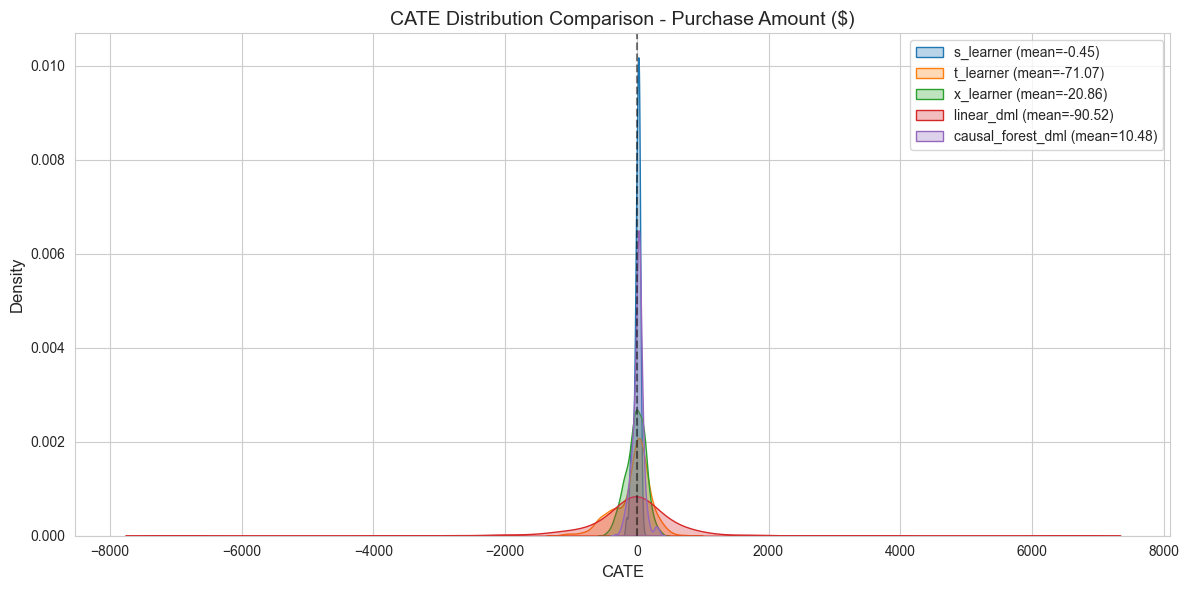

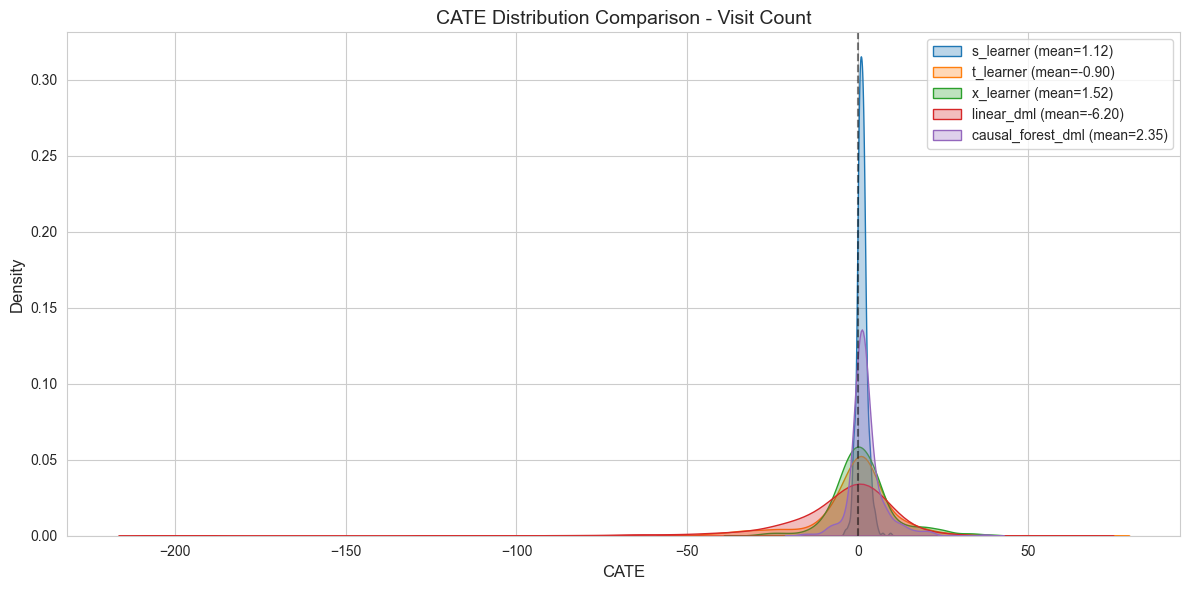

In [34]:
# CATE distribution comparison
from projects.segmentation_dunnhumby.src import plot_cate_comparison

for outcome_name, outcome_label, _ in OUTCOMES:
    fig, ax = plt.subplots(figsize=(12, 6))
    plot_cate_comparison(cate_test[outcome_name], ax=ax)
    ax.set_title(f'CATE Distribution Comparison - {outcome_label}')
    fig.tight_layout()
    fig.savefig(FIG_PATH / f'cate_distribution_{outcome_name}.png', dpi=150, bbox_inches='tight')
    plt.show()

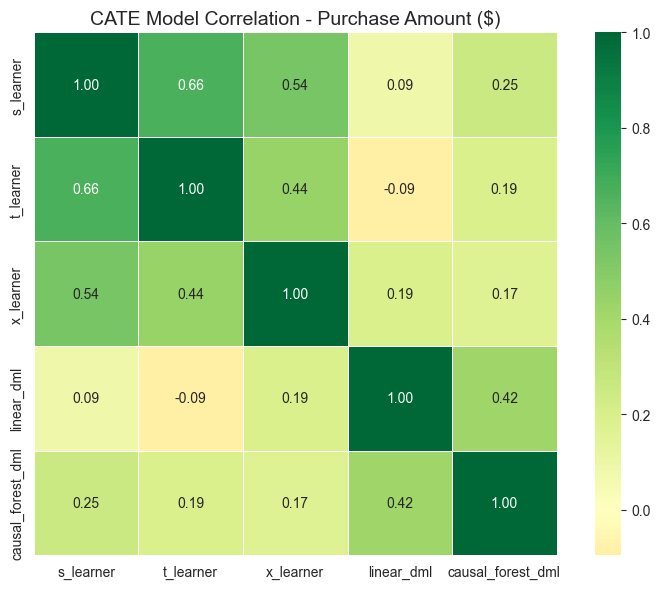

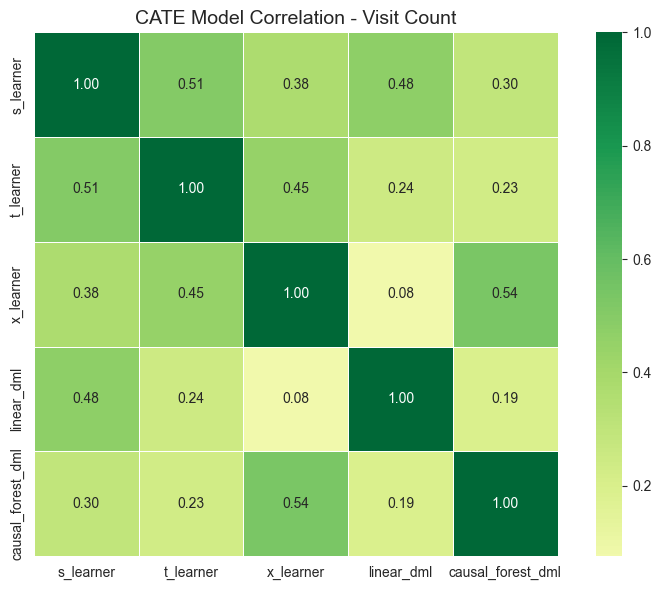

In [35]:
# Model correlation heatmap
from projects.segmentation_dunnhumby.src import plot_model_comparison_heatmap

for outcome_name, outcome_label, _ in OUTCOMES:
    # Create correlation DataFrame
    df_cate = pd.DataFrame(cate_test[outcome_name])
    
    fig, ax = plt.subplots(figsize=(8, 6))
    plot_model_comparison_heatmap(df_cate, ax=ax)
    ax.set_title(f'CATE Model Correlation - {outcome_label}')
    fig.tight_layout()
    fig.savefig(FIG_PATH / f'cate_correlation_{outcome_name}.png', dpi=150, bbox_inches='tight')
    plt.show()

## 6. Export Results

### CATE Model Comparison

**CATE Model Comparison:**

| Model | Mean CATE | Std Dev | Range | Stability |
|-------|-----------|---------|-------|-----------|
| s_learner | -$0.45 | $49 | [-$168, $105] | High |
| t_learner | -$71 | $281 | [-$1136, $757] | Low |
| x_learner | -$21 | $148 | [-$466, $363] | Medium |
| linear_dml | -$91 | $851 | [-$7033, $6606] | Very Low |
| causal_forest_dml | +$10 | $88 | [-$328, $355] | **High** |

**Model Selection Recommendations:**

1. **Primary Model: CausalForestDML**
   - Most stable predictions (std=$88)
   - Positive mean CATE (+$10)
   - Best suited for heterogeneous effects

2. **Sensitivity Check: S-Learner**
   - Simple and stable
   - Conservative estimates

3. **Avoid for Targeting: LinearDML**
   - Extreme variance (std=$851)
   - Likely overfitting to noise

**Key Insight:**
> Model disagreement (correlation 0.2-0.4 between models) indicates substantial uncertainty
> in individual-level predictions. CausalForestDML provides the best balance of flexibility
> and stability.

**Validation Plan for 03b:**
- Confirm HTE existence with BLP test
- Validate model ranking with AUUC/Qini metrics
- Assess reliability through PS region analysis

In [36]:
# Prepare results for export
export_results = {
    # Data
    'X_train': X_train,
    'X_test': X_test,
    'X_full': X_full,
    'T_train': T_train,
    'T_test': T_test,
    'T_full': T_full,
    'Y_purchase_train': Y_purchase_train,
    'Y_purchase_test': Y_purchase_test,
    'Y_purchase_full': Y_purchase,
    'Y_visits_train': Y_visits_train,
    'Y_visits_test': Y_visits_test,
    'Y_visits_full': Y_visits,
    'idx_train': idx_train,
    'idx_test': idx_test,
    
    # Propensity scores
    'ps_train': ps_train,
    'ps_test': ps_test,
    'ps_full': ps_full,
    
    # Diagnostics
    'diagnostics': diagnostics,
    'df_balance': df_balance,
    
    # ATE results
    'ate_results_df': ate_results_df,
    
    # CATE results
    'cate_train': cate_train,
    'cate_test': cate_test,
    'cate_models': cate_models,  # Trained models for further prediction
    
    # Tuning results (if performed)
    'tuning_results': tuning_results if tuning_results else None,
    'tuned_configs': tuned_configs if tuned_configs else None,
    
    # Metadata
    'feature_names': feature_names,
    'selected_models': selected_models,
    'df_scenario1': df_scenario1,  # Full cohort DataFrame
}

# Save
export_path = RESULTS_PATH / 'hte_estimation_results.joblib'
joblib.dump(export_results, export_path)
print(f"Results saved to: {export_path}")
print(f"File size: {export_path.stat().st_size / 1024 / 1024:.1f} MB")

Results saved to: /Users/taehyun/project/side-projects/projects/segmentation_dunnhumby/results/hte_estimation_results.joblib
File size: 122.3 MB


In [37]:
# Save ATE results as CSV
for outcome_name, df_ate in ate_results_df.items():
    csv_path = TABLE_PATH / f'ate_results_{outcome_name}.csv'
    df_ate.to_csv(csv_path, index=False)
    print(f"Saved: {csv_path}")

Saved: /Users/taehyun/project/side-projects/projects/segmentation_dunnhumby/results/tables/ate_results_purchase_amount.csv
Saved: /Users/taehyun/project/side-projects/projects/segmentation_dunnhumby/results/tables/ate_results_purchase_count.csv


## Summary

### Key Findings

**Positivity Diagnostics:**
- PS AUC indicates treatment/control separation level
- Overlap ratio shows proportion in common support
- High PS AUC (>0.9) suggests positivity violation

**ATE Estimates:**
- Multiple methods provide different estimates
- DML and AIPW are doubly robust
- ATO focuses on overlap region

**ATE Robustness:**
- Trimming sensitivity shows ATE stability across PS thresholds
- Manski bounds provide partial identification
- E-value assesses sensitivity to unmeasured confounding

**CATE Models:**
- 5 models trained using Optuna tuning
- Correlation between models indicates agreement

### Next Steps

Continue to `03b_hte_validation.ipynb` for:
- HTE validation (BLP test, uplift curves)
- CATE by PS region analysis
- Business impact (segment CATE, ROI simulation)